<p align="center">
    <img src="https://github.com/YoungsukHan/Hyundai_equip/assets/44924554/076ffad6-abf4-431b-af15-10373ba06182" align="center">
</p>

# <b>[ML] 용해탱크 시계열 데이터 실습 

**제목:** 용해탱크 설비운영 데이터 기반 제품의 최종품질을 예측<br>
**Description:** 용해탱크로부터 수집한 설비운영 데이터를 수집 후, 머신러닝 모형을 학습하여 제품의 최종품질을 예측함

https://www.kamp-ai.kr/aidataDetail?AI_SEARCH=&page=1&DATASET_SEQ=8

<img src="https://www.kamp-ai.kr/mnt/dataset/8/images/1.png">

<img src="https://github.com/seohyunc/hyundai/blob/main/img/melting_process.png?raw=true" width="40%"/>

## **1. 데이터 불러오기**

In [1]:
import time
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import *
from imblearn.under_sampling import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
# 데이터셋 불러오기
df = pd.read_csv('dataset/melting_tank.csv', encoding='cp949')
df.head()

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
0,2020-03-04 0:00,0,489,116,631,3.19,OK
1,2020-03-04 0:00,1,433,78,609,3.19,OK
2,2020-03-04 0:00,2,464,154,608,3.19,OK
3,2020-03-04 0:00,3,379,212,606,3.19,OK
4,2020-03-04 0:00,4,798,1736,604,3.21,OK


In [3]:
df['STD_DT'] = pd.to_datetime(df['STD_DT'], format='%Y-%m-%d %H:%M')

In [4]:
# STD_DT에 초 추가 (6초 단위로 기록)
for i in range(10):
    df.loc[df['NUM']%10==i, 'STD_DT'] = df.loc[df['NUM']%10==i, 'STD_DT'] + pd.to_timedelta(6*i, unit='s')

# 인덱스를 시간으로 지정
df = df.set_index(['STD_DT'])
df.drop(columns=['NUM'], axis=1, inplace=True)

df.head()

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
STD_DT,,,,,
2020-03-04 00:00:00,489,116,631,3.19,OK
2020-03-04 00:00:06,433,78,609,3.19,OK
2020-03-04 00:00:12,464,154,608,3.19,OK
2020-03-04 00:00:18,379,212,606,3.19,OK
2020-03-04 00:00:24,798,1736,604,3.21,OK


In [5]:
# 데이터셋 불균형 확인
df['TAG'].value_counts()

TAG
OK    658133
NG    177067
Name: count, dtype: int64

In [6]:
# 데이터 개수 확인
# .shape[0]: 열의 개수 / .shape[1]: 행의 개수
df.shape

(835200, 5)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 835200 entries, 2020-03-04 00:00:00 to 2020-04-30 23:59:54
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   MELT_TEMP    835200 non-null  int64  
 1   MOTORSPEED   835200 non-null  int64  
 2   MELT_WEIGHT  835200 non-null  int64  
 3   INSP         835200 non-null  float64
 4   TAG          835200 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 38.2+ MB


## **2. 데이터 특성 파악**

**요약 통계량**

In [8]:
# 데이터셋 통계 요약
df.describe()

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP
count,835200.000000,835200.000000,835200.000000,835200.000000
mean,509.200623,459.782865,582.962125,3.194853
std,128.277519,639.436413,1217.604433,0.011822
min,308.000000,0.000000,0.000000,3.170000
25%,430.000000,119.000000,186.000000,3.190000
50%,469.000000,168.000000,383.000000,3.190000
75%,502.000000,218.000000,583.000000,3.200000
max,832.000000,1804.000000,55252.000000,3.230000


In [9]:
df_desc = df.groupby(['TAG']).describe().T.reset_index()
df_desc = df_desc.loc[df_desc['level_1'].isin(['mean', 'min', 'max'])]
df_desc.pivot(index='level_0', columns='level_1', values=['NG', 'OK'])

NG                            OK                    
level_1           max        mean     min       max        mean     min
level_0                                                                
INSP             3.21    3.188640    3.17      3.23    3.196524    3.17
MELT_TEMP      555.00  432.390112  308.00    832.00  529.866061  311.00
MELT_WEIGHT  55252.00  611.327763    0.00  52727.00  575.330509    0.00
MOTORSPEED     270.00  133.474696    0.00   1804.00  547.574252    0.00

**Histogram**

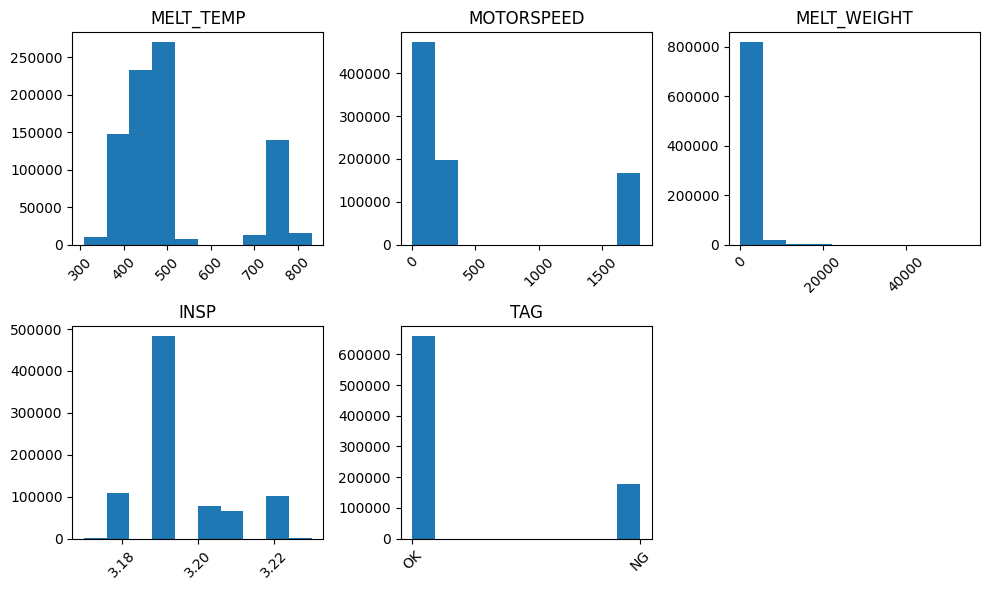

In [10]:
plt.figure(figsize=(10,6))

for i, col in enumerate(df.columns):
    num = 231+i
    plt.subplot(num)
    plt.hist(df[col])
    plt.xticks(rotation=45)
    plt.title(col)

plt.tight_layout()
plt.show()

In [11]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html
# .sample(): 랜덤 샘플링

df_rand = df.sample(n=int(len(df)/2), random_state=0)

print(f"랜덤 샘플링 전: {df.shape}")
print(f"랜덤 샘플링 후: {df_rand.shape}")

랜덤 샘플링 전: (835200, 5)
랜덤 샘플링 후: (417600, 5)


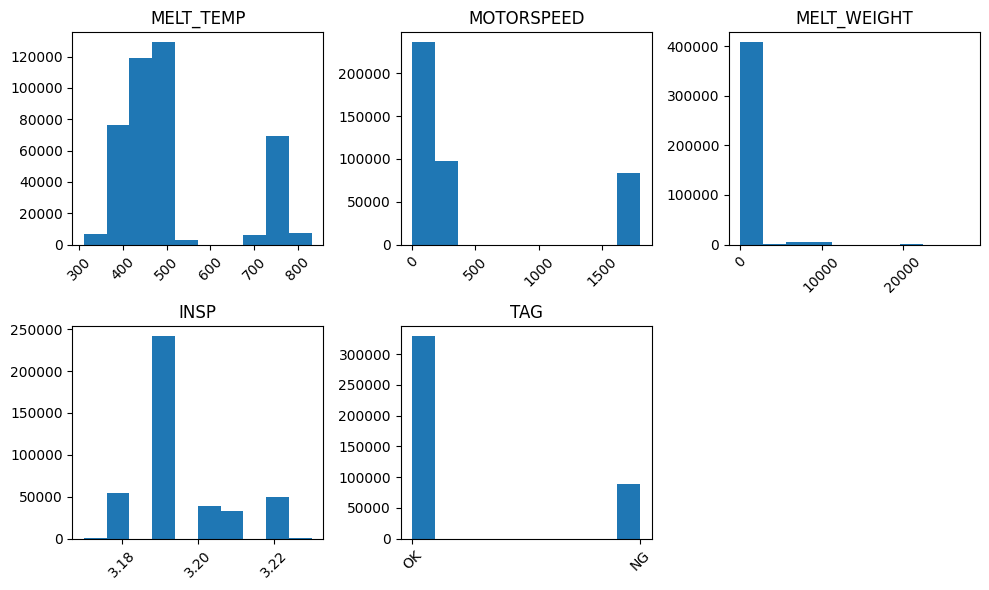

In [12]:
plt.figure(figsize=(10,6))

for i, col in enumerate(df_rand.columns):
    num = 231+i
    plt.subplot(num)
    plt.hist(df_rand[col])
    plt.xticks(rotation=45)
    plt.title(col)

plt.tight_layout()
plt.show()

In [13]:
# 범주형 변수 숫자로 인코딩

encoder = preprocessing.LabelEncoder() 
df['TAG'] = encoder.fit_transform(df['TAG'])
df['TAG'] = df['TAG'].astype('float32')

# 관심 주제를 1(NG)
# df.loc[df['TAG']=='NG', 'TAG'] = 1
# df.loc[df['TAG']=='OK', 'TAG'] = 0

In [14]:
df['TAG'].value_counts()

TAG
1.0    658133
0.0    177067
Name: count, dtype: int64

**Correlation Heatmap**

In [15]:
# 변수간 상관관계 확인

# 1)연속형(숫자로 표현 가능한) 데이터에 대해서만 상관관계 분석 가능
# 2) 범위: -1~1 (+: 양의 상관관계, -: 음의 상관관계)
# 3) 인과관계를 의미하지는 않음

df.corr()

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
MELT_TEMP,1.000000,0.944929,-0.000336,0.916295,0.310586
MOTORSPEED,0.944929,1.000000,0.000123,0.887813,0.264693
MELT_WEIGHT,-0.000336,0.000123,1.000000,-0.000005,-0.012084
INSP,0.916295,0.887813,-0.000005,1.000000,0.272580
TAG,0.310586,0.264693,-0.012084,0.272580,1.000000


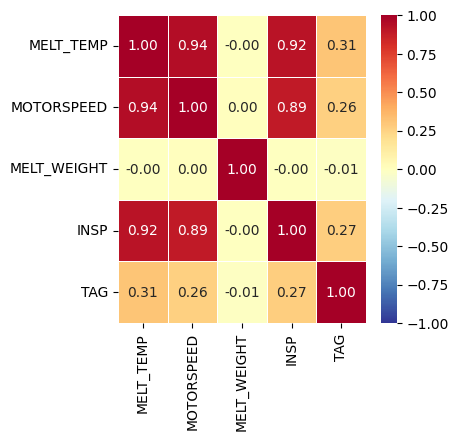

In [16]:
plt.figure(figsize=(4,4))
sns.heatmap(
    data=df.corr(),
    annot=True, 
    fmt = '.2f', 
    linewidths=.5, 
    cmap='RdYlBu_r', # Blue
    vmin=-1, vmax=1  # 컬러바 범위 -1 ~ 1
)
plt.show()

**Violin Plot**

<img src="https://blog.kakaocdn.net/dn/b0CIEt/btqCy3Aazjb/emj6zXRBK6UBUc8iolba81/img.png">

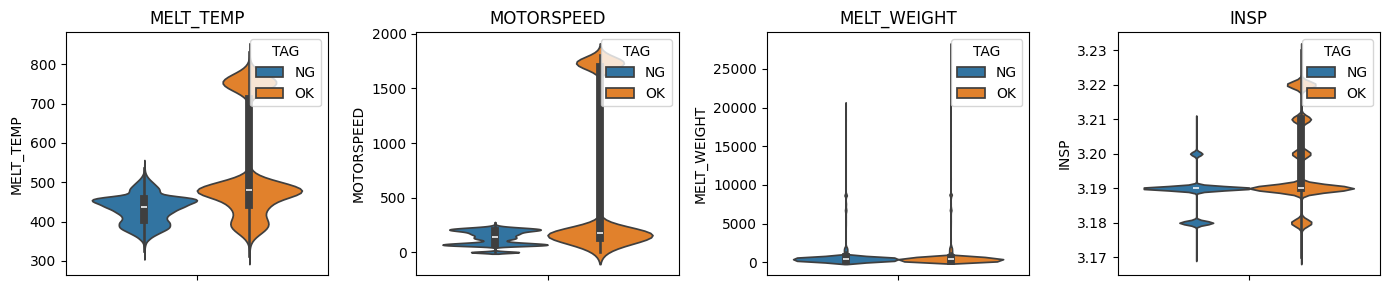

In [17]:
selected_col = ['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP']

plt.figure(figsize=(14,3))

# TAG를 제외한 변수의 바이올린차트 그리기
for i, col in enumerate(selected_col):
    num = 141+i
    plt.subplot(num)
    sns.violinplot(data=df_rand, y=col, hue='TAG', hue_order=['NG', 'OK'])
    plt.title(col)

plt.tight_layout()
plt.show()

**Scatterplot Matrix**

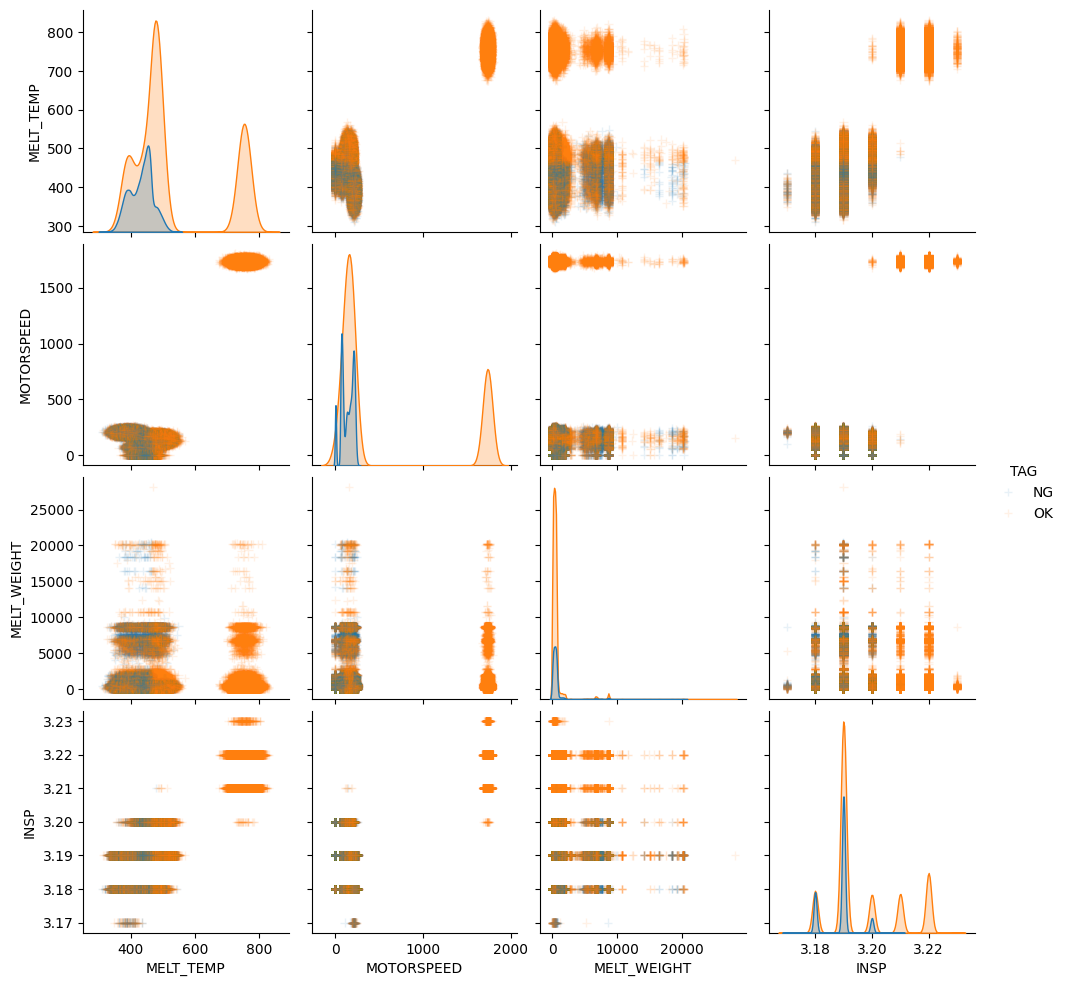

Execution time: 60.669697999954224 seconds


In [18]:
# https://seaborn.pydata.org/generated/seaborn.pairplot.html
start_time = time.time()

sns.pairplot(df_rand, diag_kind='kde', hue='TAG', hue_order=['NG', 'OK'], plot_kws=dict(marker="+", linewidth=1, alpha=0.1))
plt.show()

end_time = time.time()
print(f"Execution time: {end_time - start_time} seconds")

**Time-series Plot**

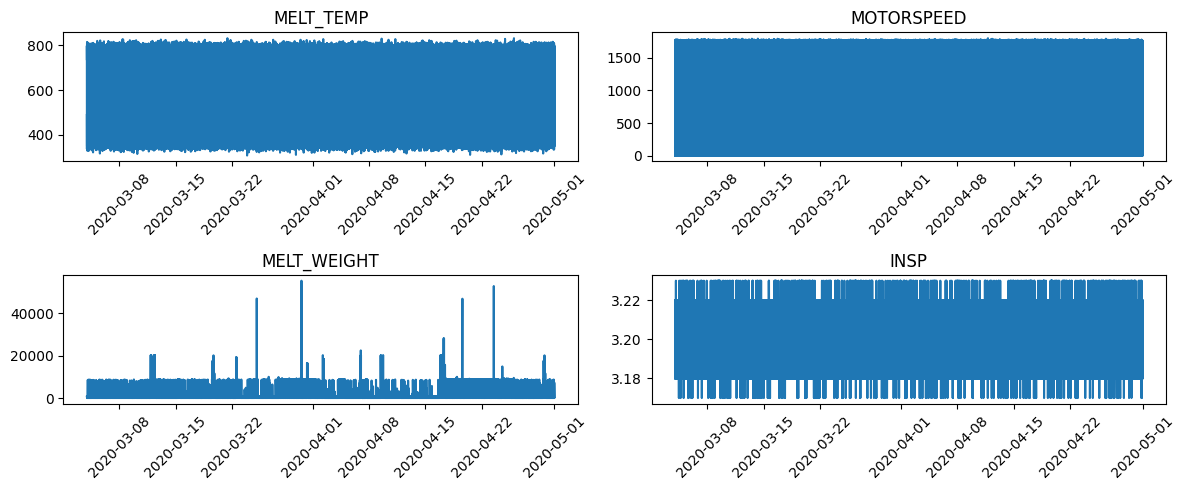

In [19]:
plt.figure(figsize=(12,5))

for i, col in enumerate(selected_col):
    num = 221+i
    plt.subplot(num)
    plt.plot(df[col])
    plt.xticks(rotation=45)
    plt.title(col)
    
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.35)    
plt.tight_layout()
plt.show()

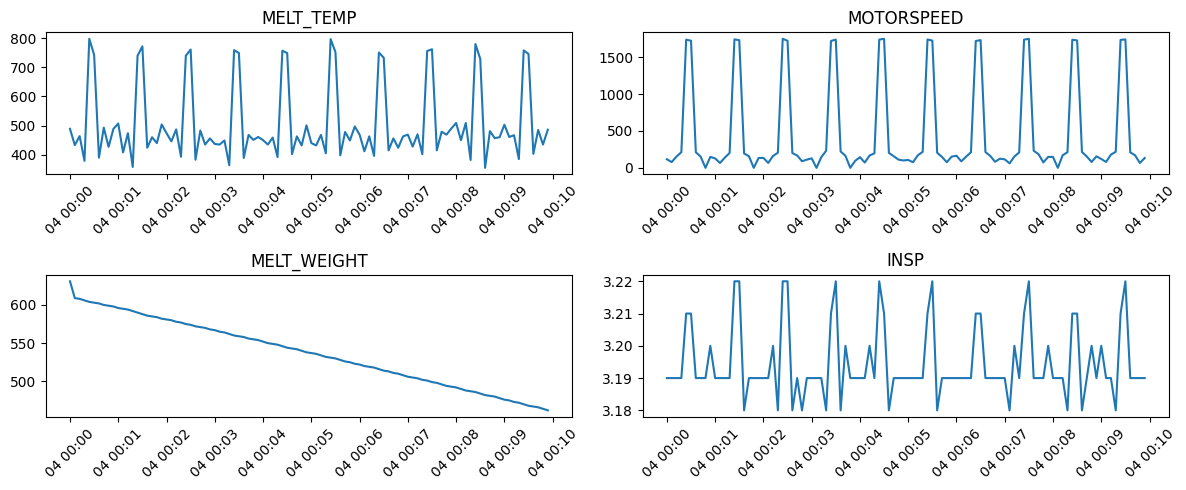

In [20]:
selected_col = ['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP']
plt.figure(figsize=(12,5))

for i, col in enumerate(selected_col):
    num = 221+i
    plt.subplot(num)
    plt.plot(df[col][0:100])
    plt.xticks(rotation=45)
    plt.title(col)
    
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.35)    
plt.tight_layout()
plt.show()

1분(10개 관측치)마다 패턴을 보였으므로, 향후 모델링에서 1분을 timestep으로 활용

## **3. 데이터 전처리**

**변수 제거**

In [21]:
# df1 = df[['MELT_TEMP', 'MOTORSPEED', 'INSP', 'TAG']]
df1 = df[['MELT_TEMP', 'MOTORSPEED', 'TAG']]

## **4. 훈련/테스트 데이터 분할**

In [22]:
split_date = int(df1.shape[0]*0.7)

train = df1[:split_date]
test = df1[split_date:]

In [23]:
print(train.shape)
print(test.shape)

(584640, 3)
(250560, 3)


In [24]:
train['TAG'].value_counts()

TAG
1.0    410516
0.0    174124
Name: count, dtype: int64

In [25]:
test['TAG'].value_counts()

TAG
1.0    247617
0.0      2943
Name: count, dtype: int64

## **5. 정규화**

In [26]:
scaler = preprocessing.MinMaxScaler()

train_sc = scaler.fit_transform(train)
test_sc = scaler.fit_transform(test)

## **6. Window 정의 및 데이터 생성**

**Window 함수 정의**

In [27]:
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []

    for i in range(len(data)-window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
        
    return np.array(feature_list), np.array(label_list)

**데이터 생성**

In [28]:
feature_cols = ['MELT_TEMP', 'MOTORSPEED']
label_cols = ['TAG']

In [29]:
%%time

# origin
X_train_origin = pd.DataFrame(train_sc[:, :-1], columns=feature_cols)
y_train_origin = pd.DataFrame(train_sc[:, -1], columns=label_cols)
X_test_origin = pd.DataFrame(test_sc[:, :-1], columns=feature_cols)
y_test_origin = pd.DataFrame(test_sc[:, -1], columns=label_cols)

CPU times: total: 0 ns
Wall time: 0 ns


In [30]:
%%time

win_size = 10

train_feature, train_label = make_dataset(X_train_origin, y_train_origin, win_size)
test_feature, test_label = make_dataset(X_test_origin, y_test_origin, win_size)

X_train_win = train_feature.reshape(train_feature.shape[0], train_feature.shape[1]*train_feature.shape[2])
y_train = train_label.ravel()

X_test_win = test_feature.reshape(test_feature.shape[0], test_feature.shape[1]*test_feature.shape[2])
y_test = test_label.ravel()

CPU times: total: 36.7 s
Wall time: 36.7 s


## **7. 모델 구축 및 훈련 / 8. 모델 평가 및 결과 해석**
- 알고리즘: Cost-Sensitive Random forest, Over/Undersampling + DT
- 검증: 5-fold cross validation, grid search

**Cost-Sensitive Random Forest**

In [75]:
y_train_origin = y_train_origin.astype(int)

In [77]:
np.bincount(y_train_origin.values.ravel())

array([174124, 410516], dtype=int64)

In [79]:
len(yy) / (2 *np.bincount(yy))

C:\Users\Seohyun\AppData\Local\Temp\ipykernel_64636\2168353748.py:1: RuntimeWarning: divide by zero encountered in divide
  len(yy) / (2 *np.bincount(yy))


array([inf, inf, inf, ..., inf, inf,  1.])

In [80]:
# class_weight
# n_samples / (n_classes * np.bincount(y))

weight_ = len(y_train_origin) / np.bincount(y_train_origin.values.ravel())

In [82]:
rf_params_cs = {
    'n_estimators': [50, 100],
    'max_depth' : [3, 4],
    'class_weight' : [{0:weight_[0], 1:weight_[1]}]  # cost-sensitive learning
}

In [83]:
rf_cs_clf = RandomForestClassifier(random_state=0)
rf_cs_grid = GridSearchCV(rf_cs_clf, param_grid=rf_params_cs, cv=5, refit=True, verbose=1, scoring='f1')

In [84]:
%%time
rf_cs_grid.fit(X_train_win, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
CPU times: total: 6min 54s
Wall time: 6min 54s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'class_weight': [{0: 3.357607222439181,
                                           1: 1.4241588634791336}],
                         'max_depth': [3, 4], 'n_estimators': [50, 100]},
             scoring='f1', verbose=1)

In [85]:
rf_cs_grid.best_params_

{'class_weight': {0: 3.357607222439181, 1: 1.4241588634791336},
 'max_depth': 4,
 'n_estimators': 100}

In [86]:
y_pred_cs = rf_cs_grid.predict(X_test_win)

In [87]:
print(f"Precision: {precision_score(y_test, y_pred_cs):0.4f}") # 모델이 1로 예측한 데이터 중 실제 1인 데이터의 비율
print(f"Recall: {recall_score(y_test, y_pred_cs):0.4f}") # 실제 1인 데이터 중 모델이 1로 예측한 데이터의 비율
print(f"F1-Score: {f1_score(y_test, y_pred_cs):0.4f}") # 정밀도와 재현율의 조화평균
print(f"Accuracy: {accuracy_score(y_test, y_pred_cs):0.4f}")
print("-----------")
print(classification_report(y_test, y_pred_cs))

Precision: 0.9956
Recall: 0.6044
F1-Score: 0.7522
Accuracy: 0.6064
-----------
              precision    recall  f1-score   support

         0.0       0.02      0.77      0.04      2940
         1.0       1.00      0.60      0.75    247610

    accuracy                           0.61    250550
   macro avg       0.51      0.69      0.40    250550
weighted avg       0.98      0.61      0.74    250550



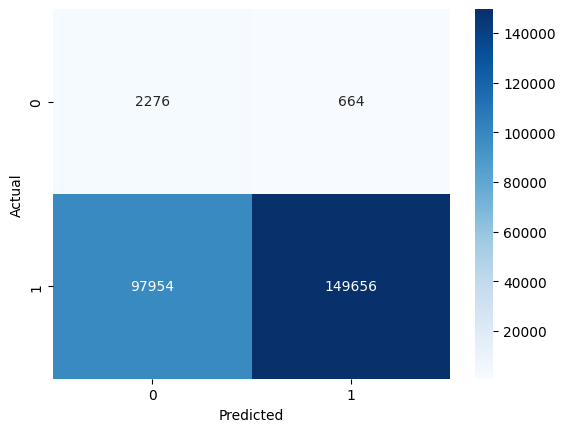

In [88]:
# plt.figure(figsize=(3, 3))
cm = confusion_matrix(y_test, y_pred_cs)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

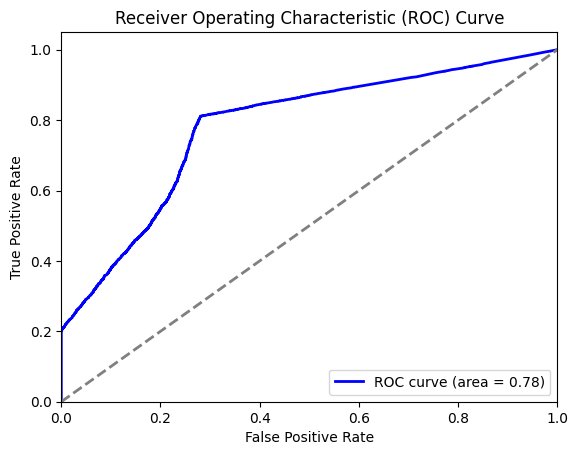

In [96]:
from sklearn.metrics import roc_auc_score

y_proba_cs = rf_cs_grid.predict_proba(X_test_win)[:,1]
roc_auc = roc_auc_score(y_test, y_proba_cs)
fpr, tpr, thresholds = roc_curve(y_test, y_proba_cs)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

**Upsampling**

In [40]:
%%time
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train_win, y_train)

CPU times: total: 2min 9s
Wall time: 13.2 s


In [42]:
print(f"샘플링 적용 전 피처/레이블 데이터 수: {X_train_origin.shape}", {y_train.shape})
print(f"샘플링 적용 후 피처/레이블 데이터 수: {X_train_over.shape}", {y_train_over.shape})
print("-----------")
print(f"샘플링 후 레이블 값 분포:\n{pd.Series(y_train_over).value_counts()}")

샘플링 적용 전 피처/레이블 데이터 수: (584640, 2) {(584630,)}
샘플링 적용 후 피처/레이블 데이터 수: (821012, 20) {(821012,)}
-----------
샘플링 후 레이블 값 분포:
1.0    410506
0.0    410506
Name: count, dtype: int64


**Decision Tree** <br>
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [43]:
dt_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [3, 4],
}

In [44]:
dt_clf = DecisionTreeClassifier(random_state=0)

In [45]:
dt_grid = GridSearchCV(estimator=dt_clf, param_grid=dt_params, cv=5, refit=True, scoring='f1', verbose=1)

In [46]:
%%time
dt_grid.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
CPU times: total: 1min 42s
Wall time: 1min 42s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [3, 4]},
             scoring='f1', verbose=1)

In [47]:
y_pred_dt = dt_grid.predict(X_test_win)

print(f"Precision: {precision_score(y_test, y_pred_dt):0.4f}")
print(f"Recall: {recall_score(y_test, y_pred_dt):0.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_dt):0.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):0.4f}")
print("-----------")
print(classification_report(y_test, y_pred_dt))

Precision: 0.9955
Recall: 0.6052
F1-Score: 0.7528
Accuracy: 0.6072
-----------
              precision    recall  f1-score   support

         0.0       0.02      0.77      0.04      2940
         1.0       1.00      0.61      0.75    247610

    accuracy                           0.61    250550
   macro avg       0.51      0.69      0.40    250550
weighted avg       0.98      0.61      0.74    250550



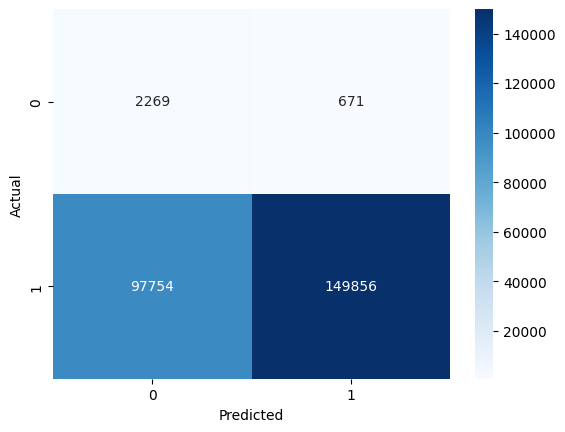

In [48]:
# plt.figure(figsize=(3, 3))
cm = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

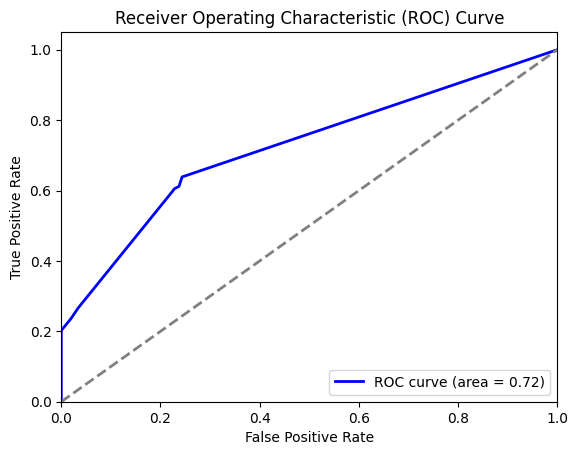

In [95]:
from sklearn.metrics import roc_auc_score

y_proba_dt = dt_grid.predict_proba(X_test_win)[:,1]
roc_auc = roc_auc_score(y_test, y_proba_dt)
fpr, tpr, thresholds = roc_curve(y_test, y_proba_dt)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

**Random Forest**

In [49]:
rf_clf = RandomForestClassifier(random_state=0)

In [50]:
params = {
    'n_estimators': [50, 100],
    'max_depth' : [3, 4],
}

In [51]:
rf_grid = GridSearchCV(estimator=rf_clf, param_grid=params, cv=5, refit=True, scoring='f1', verbose=1)

In [52]:
%%time
rf_grid.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
CPU times: total: 22min 9s
Wall time: 22min 9s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 4], 'n_estimators': [50, 100]},
             scoring='f1', verbose=1)

In [53]:
rf_grid.best_params_

{'max_depth': 4, 'n_estimators': 100}

In [54]:
y_pred_rf = rf_grid.predict(X_test_win)

In [55]:
print(f"Precision: {precision_score(y_test, y_pred_rf):0.4f}") # 모델이 1로 예측한 데이터 중 실제 1인 데이터의 비율
print(f"Recall: {recall_score(y_test, y_pred_rf):0.4f}") # 실제 1인 데이터 중 모델이 1로 예측한 데이터의 비율
print(f"F1-Score: {f1_score(y_test, y_pred_rf):0.4f}") # 정밀도와 재현율의 조화평균
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):0.4f}")
print("-----------")
print(classification_report(y_test, y_pred_rf))

Precision: 0.9956
Recall: 0.6044
F1-Score: 0.7522
Accuracy: 0.6064
-----------
              precision    recall  f1-score   support

         0.0       0.02      0.77      0.04      2940
         1.0       1.00      0.60      0.75    247610

    accuracy                           0.61    250550
   macro avg       0.51      0.69      0.40    250550
weighted avg       0.98      0.61      0.74    250550



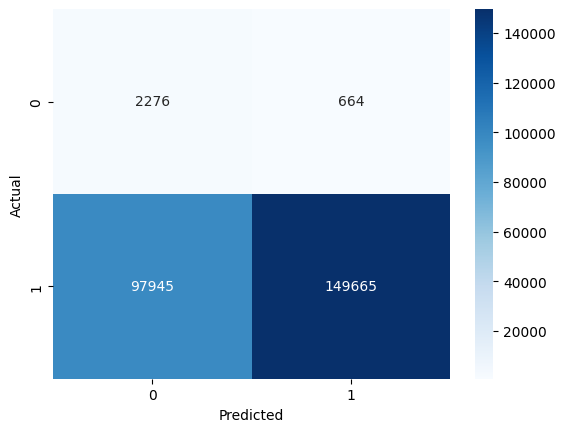

In [56]:
# plt.figure(figsize=(3, 3))
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

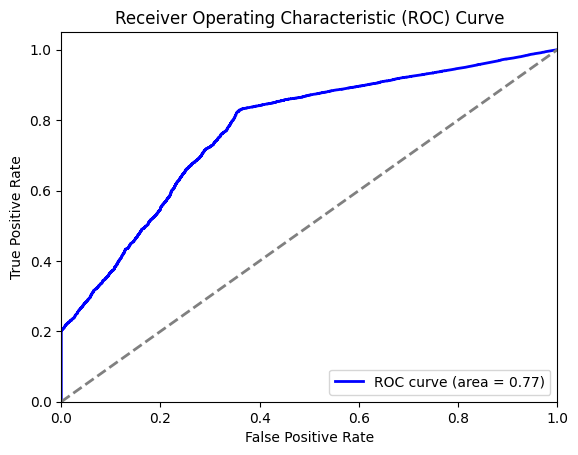

In [97]:
from sklearn.metrics import roc_auc_score

y_proba_rf = rf_grid.predict_proba(X_test_win)[:,1]
roc_auc = roc_auc_score(y_test, y_proba_rf)
fpr, tpr, thresholds = roc_curve(y_test, y_proba_rf)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()